In [3]:
import joblib
# from google.colab import drive

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from joblib import load

from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics

In [4]:
# from google.colab import drive
# drive.mount('/content/drive/')

In [5]:
import pathlib
# model did not import correctly. Rebuilt
svc_pipe = Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler()),
                                                                  ('binner',
                                                                   KBinsDiscretizer(n_bins=4))]),
                                                  ['d_chall_score', 'aoa_max',
                                                   'conc_rating_max',
                                                   'num_lemmas']),
                                                 ('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_df=0.5,
                                                                                   ngram_range=(1,
                                                                                                3)))]),
                                                  'lemmatized_text')])),
                ('svc',
                 CalibratedClassifierCV(base_estimator=LinearSVC(C=0.5,
                                                                 dual=False,
                                                                 max_iter=10000,
                                                                 penalty='l1',
                                                                 random_state=99)))])

In [6]:
# Sample size
n = -1

# Which numeric features to include
features = {
    'd_chall_score': True, 
    'aoa_mean': False, 
    'aoa_min': False, 
    'aoa_max': True,
    'conc_rating_mean': False, 
    'conc_rating_min': False, 
    'conc_rating_max': True, 
    'num_lemmas': True
}

In [7]:
# load datasets
train = pd.read_csv('assets/Training_set.csv', delimiter='\t', index_col='ix')
train['lemmatized_text'] = train['lemmatized_text'].fillna('')

test = pd.read_csv('assets/Testing_set.csv', delimiter='\t', index_col='ix')
test['lemmatized_text'] = test['lemmatized_text'].fillna('')

merged = pd.concat([train, test])

# collect feature list for df slicing
num_features = [k for k,v in features.items() if v]
txt_features = 'lemmatized_text'

In [8]:
# split with balanced classes
if n==-1:
  sample = merged
else:
  sample = merged.groupby('label').apply(lambda grp: grp.sample(int(n/2)))

X = sample[num_features + [txt_features]]
y = sample['label']

In [24]:
# fit learning curve
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(svc_pipe, X, y, cv=5, return_times=True, n_jobs=6)

# mean and variance
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

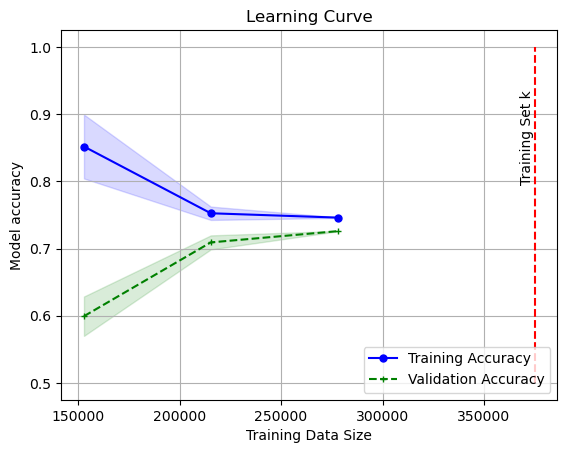

In [16]:
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.vlines(len(train), 0.5, 1.0, linestyles='--', color='red')
plt.text(len(train)*0.98, 0.8, 'Training Set k', rotation=90)
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.savefig('svc_learning_curve', dpi=600)
plt.show()